#### Aim
_classify texts written by students into three categories: efective, adequate, ineffective_ <br>
_eval method: multi class log loss_

In [367]:
import pandas as pd
import numpy as np

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
sns.set_palette('Spectral_r')

#### Initial steps 
Remarks:
- _'discourse effectiveness' is the target variable_ 
    - somewhat unbalanced
        - adequate: .57
        - effective: .25
        - ineffective: .17
<br>
<br>
- _'discourse_id' unique for each entry_

- _'essay_id' denotes the context; text can be loaded in the for more inherent information_
    - _seems to be normally distributed, each essay appearing ~ 10x_
<br>
<br>
- _'discourse_type' is a catgorical feature with 7 unique categories: 
    - _'Rebuttal', 'Counterclaim', 'Lead', 'Concluding Statement', 'Position',
       'Claim', 'Evidence'_
    - Frequency: 
        'Rebuttal': 0.03383653, 
        'Counterclaim': 0.04822521, 
        'Lead': 0.0623147 , 
        'Concluding Statement': 0.09114647, 
        'Position': 0.10945192,
        __'Claim' : 0.32577179__, 
        __'Evidence': 0.32925337__

<br>
<br>
- TODO: _'discourse_text'_
<br>
- TODO: _'essay_text'_


<br>
<br>

- Questions to think about: 
    - What makes an argument effective? And, conversely one ineffective?
    - Does the degree of formalness matter? What kind of language is used?
    - Is it relatedness to the topic at hand?
    
    - Why does _discourse type_ matter?
         

####  Data reading, info, describe


In [298]:
train_path = "train.csv"
test_path =  "test.csv"

In [299]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train['essay_text'] = train['essay_id'].apply(lambda x: open(f"train/{x}.txt").read())
test['essay_text'] = test['essay_id'].apply(lambda x: open(f"test/{x}.txt").read())

In [300]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
 5   essay_text               36765 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


In [301]:
train.describe().T

,count,unique,top,freq
discourse_id,36765,36765,0013cc385424,1
essay_id,36765,4191,91B1F82B2CF1,23
discourse_text,36765,36691,Summer projects should be student-designed,14
discourse_type,36765,7,Evidence,12105
discourse_effectiveness,36765,3,Adequate,20977
essay_text,36765,4191,Many people may think that attending school on...,23


In [302]:
test.describe().T

,count,unique,top,freq
discourse_id,10,10,a261b6e14276,1
essay_id,10,1,D72CB1C11673,10
discourse_text,10,10,Making choices in life can be very difficult. ...,1
discourse_type,10,5,Claim,4
essay_text,10,1,Making choices in life can be very difficult. ...,10


In [303]:
train.head(25)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,"Hi, i'm Isaac, i'm going to be writing about h..."
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,Limiting the usage of cars has personal and pr...


In [304]:
train.discourse_text

0        Hi, i'm Isaac, i'm going to be writing about h...
1        On my perspective, I think that the face is a ...
2        I think that the face is a natural landform be...
3        If life was on Mars, we would know by now. The...
4        People thought that the face was formed by ali...
                               ...                        
36760    For many people they don't like only asking on...
36761    also people have different views and opinions ...
36762    Advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object

#### Essay_id

In [305]:
subset = train.essay_id.value_counts()
subset

91B1F82B2CF1    23
4CA37D113612    23
900A879708F0    23
A7EC6F462F8B    22
DECAE402BB38    22
                ..
AB02689C1A9B     1
FFFF80B8CC2F     1
377548575048     1
5E85F1FB4E22     1
9706F8E7D534     1
Name: essay_id, Length: 4191, dtype: int64

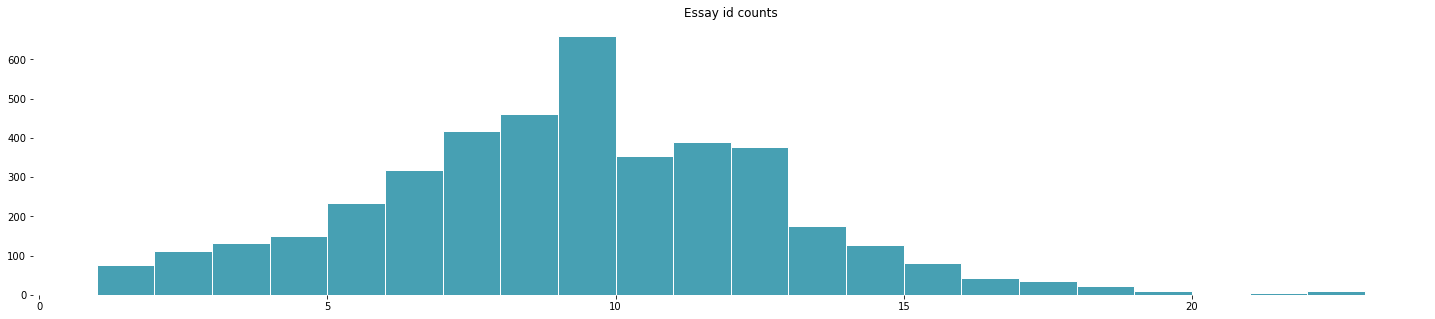

In [306]:
plt.figure(figsize = (25,5))
plt.hist(subset.values, rwidth = 1, bins = 22, align='mid', edgecolor = 'white')
plt.title('Essay id counts')
plt.box(False)
plt.show()

The majority of essays appear ~10 times.


#### Discourse effectiveness

In [307]:
subset = train.discourse_effectiveness.value_counts(ascending=True)
subset = subset / len(train)

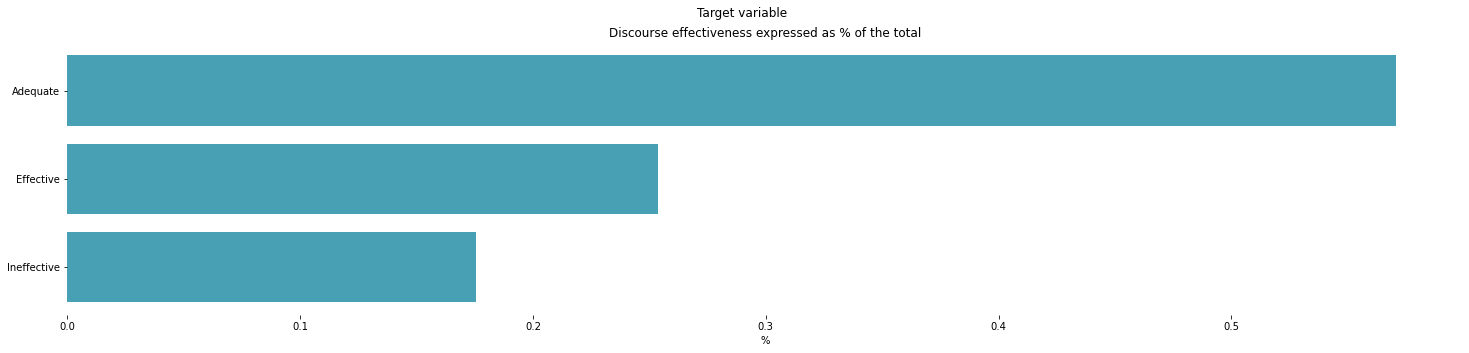

In [308]:
plt.figure(figsize = (25,5))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse effectiveness expressed as % of the total')
plt.suptitle('Target variable')
plt.xlabel('%')
plt.box(False)
plt.show()

In [309]:
subset.values

array([0.17576499, 0.25366517, 0.57056984])

So it it somewhat unbalanced.

In [310]:
len(train) - train.discourse_text.nunique() 

74

There are 74 instances where one or more _discourse_texts_ is repeated.

#### Discourse_text 

In [311]:
subset = train.discourse_type.value_counts(ascending=True)
subset = subset / len(train)

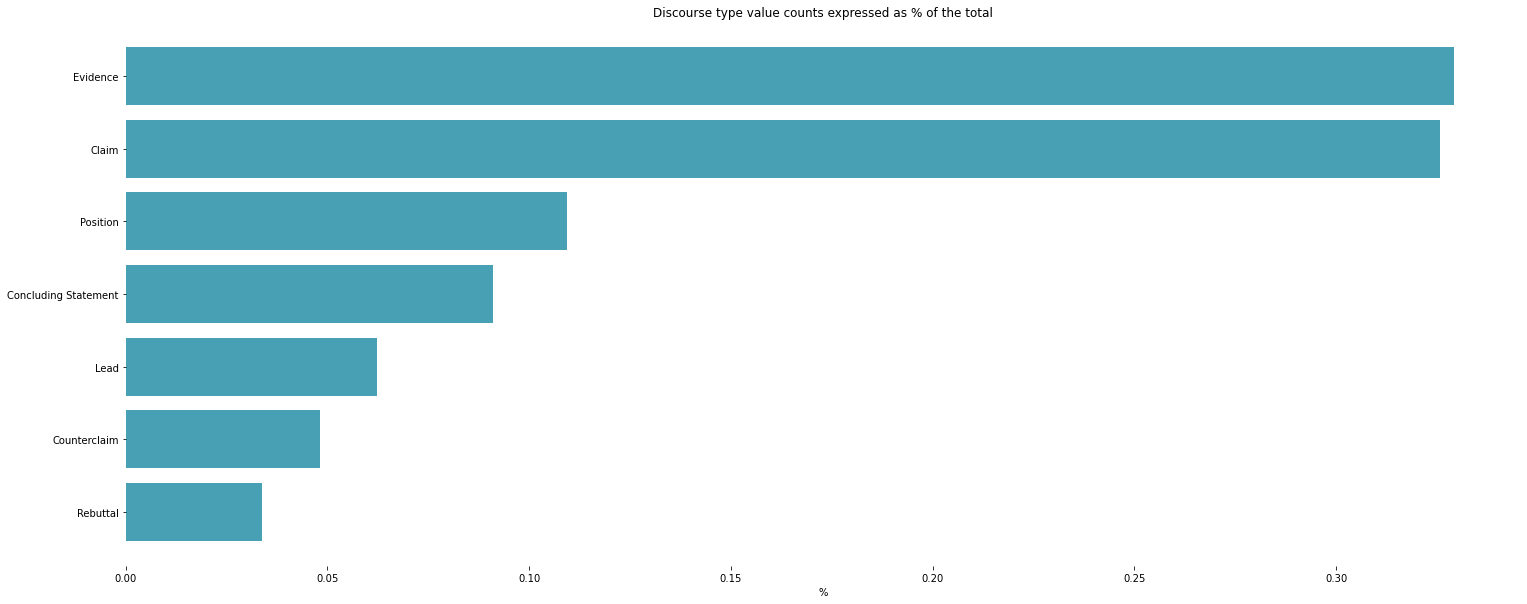

In [312]:
plt.figure(figsize = (25,10))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse type value counts expressed as % of the total')
plt.xlabel('%')
plt.box(False)
plt.show()

In [313]:
subset.values

array([0.03383653, 0.04822521, 0.0623147 , 0.09114647, 0.10945192,
       0.32577179, 0.32925337])

In [314]:
subset = train.loc[train.discourse_effectiveness == 'Adequate'].discourse_type
subset = sorted(subset)

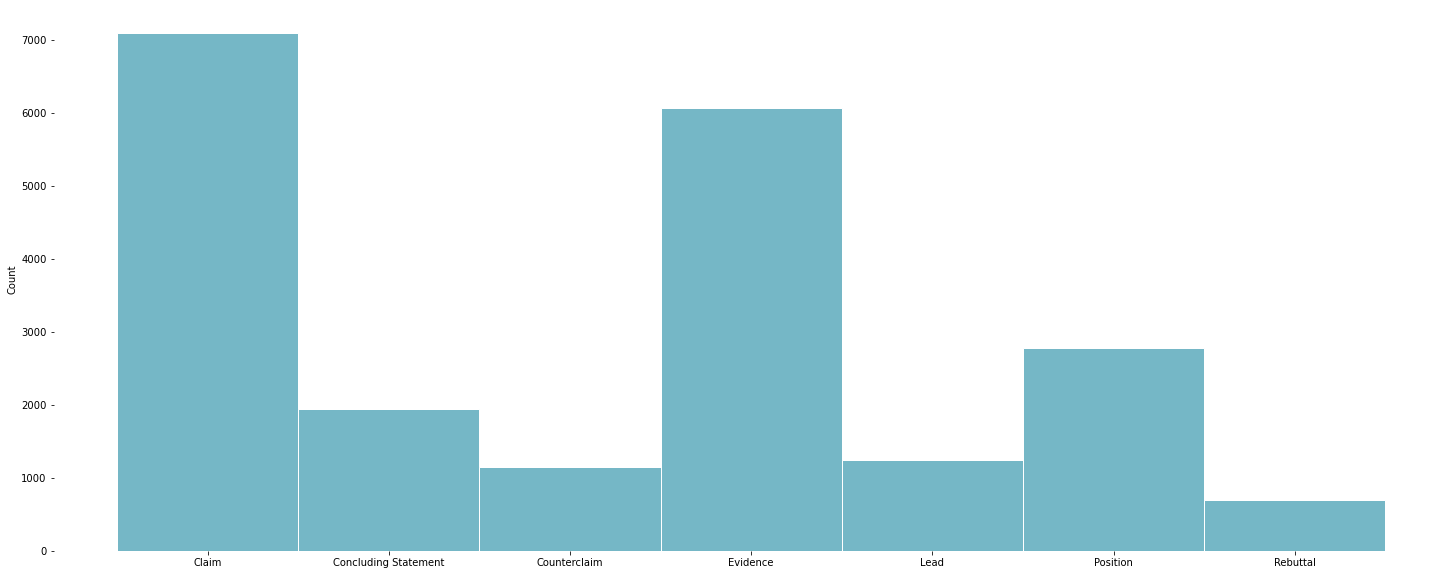

In [315]:
plt.figure(figsize = (25,10))
sns.histplot(subset, edgecolor = 'white')
plt.box(False)

In [316]:
subset = train.discourse_text.str.len()
subset

0        317
1        210
2        105
3        362
4        101
        ... 
36760    126
36761     57
36762    121
36763    439
36764     67
Name: discourse_text, Length: 36765, dtype: int64

#### Discourse text 2

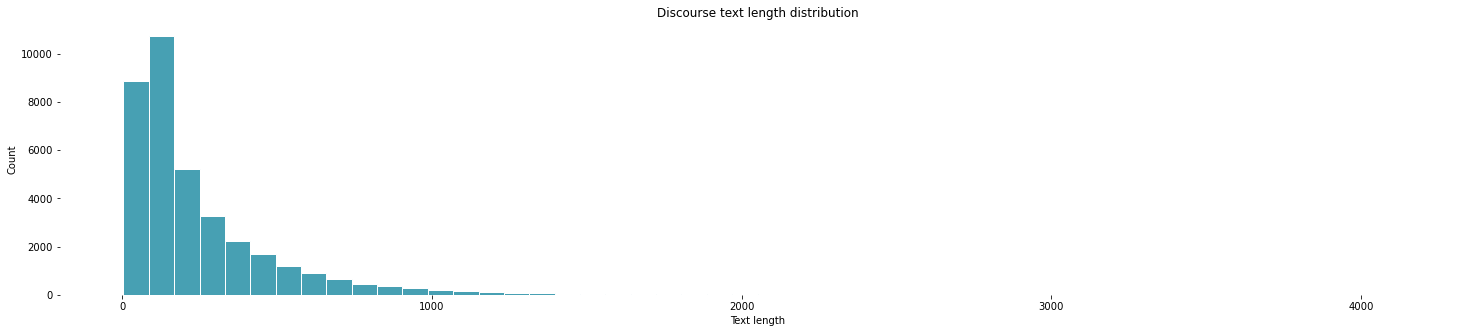

In [317]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text length distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.box(False)
plt.show()

In [318]:
subset = train.discourse_text.str.split(' ').map(len)
subset

0        68
1        42
2        22
3        73
4        19
         ..
36760    22
36761    10
36762    24
36763    82
36764    12
Name: discourse_text, Length: 36765, dtype: int64

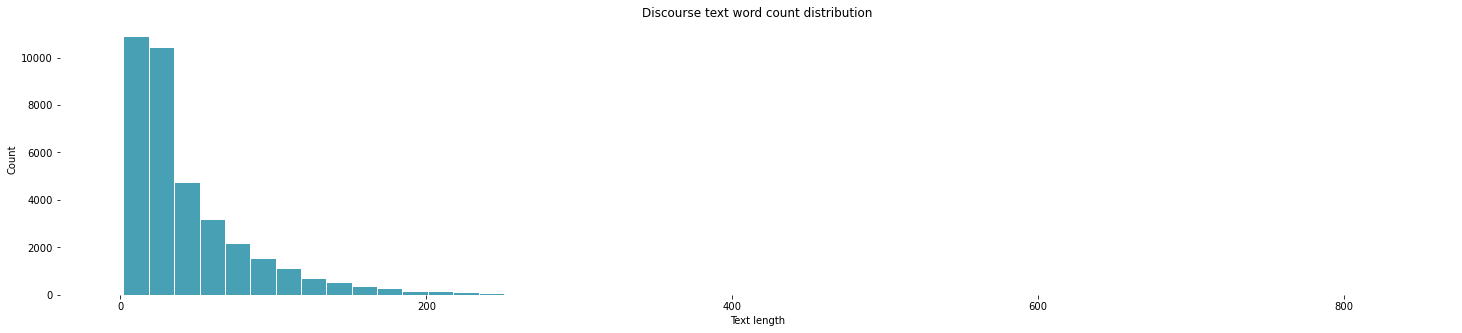

In [319]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text word count distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.box(False)
plt.show()

####  Why and how does _discourse type_ matter?

In [320]:
train[train.loc[:, 'discourse_type'] == 'Lead']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,Limiting the usage of cars has personal and pr...
20,ed7e62a18bad,00BD97EA4041,Should computers read the emotional expression...,Lead,Adequate,Should computers read the emotional expression...
33,ed3a833a2f49,013B9AA6B9DB,What is that thing on Mars?,Lead,Adequate,"What is that thing on Mars?\n\nWell, some peop..."
44,55f4bc9b664b,0158970BC5D2,Students around the world are forgetting more ...,Lead,Adequate,Students around the world are forgetting more ...
...,...,...,...,...,...,...
36699,c42e3ed1626b,FD8A9514C8BC,Not too long ago I got into a disagreement wit...,Lead,Adequate,Not too long ago I got into a disagreement wit...
36708,d934843f1543,FDF0AEEB14C3,Going to school everyday can be difficult for ...,Lead,Effective,Going to school everyday can be difficult for ...
36723,bf5f089e19df,FE3CA06DDCA1,Why is it when someone asks you for advice the...,Lead,Ineffective,Why is it when someone asks you for advice the...
36730,cea348b818a9,FEF42864AE28,"During a long day at school, have you ever tho...",Lead,Effective,"During a long day at school, have you ever tho..."


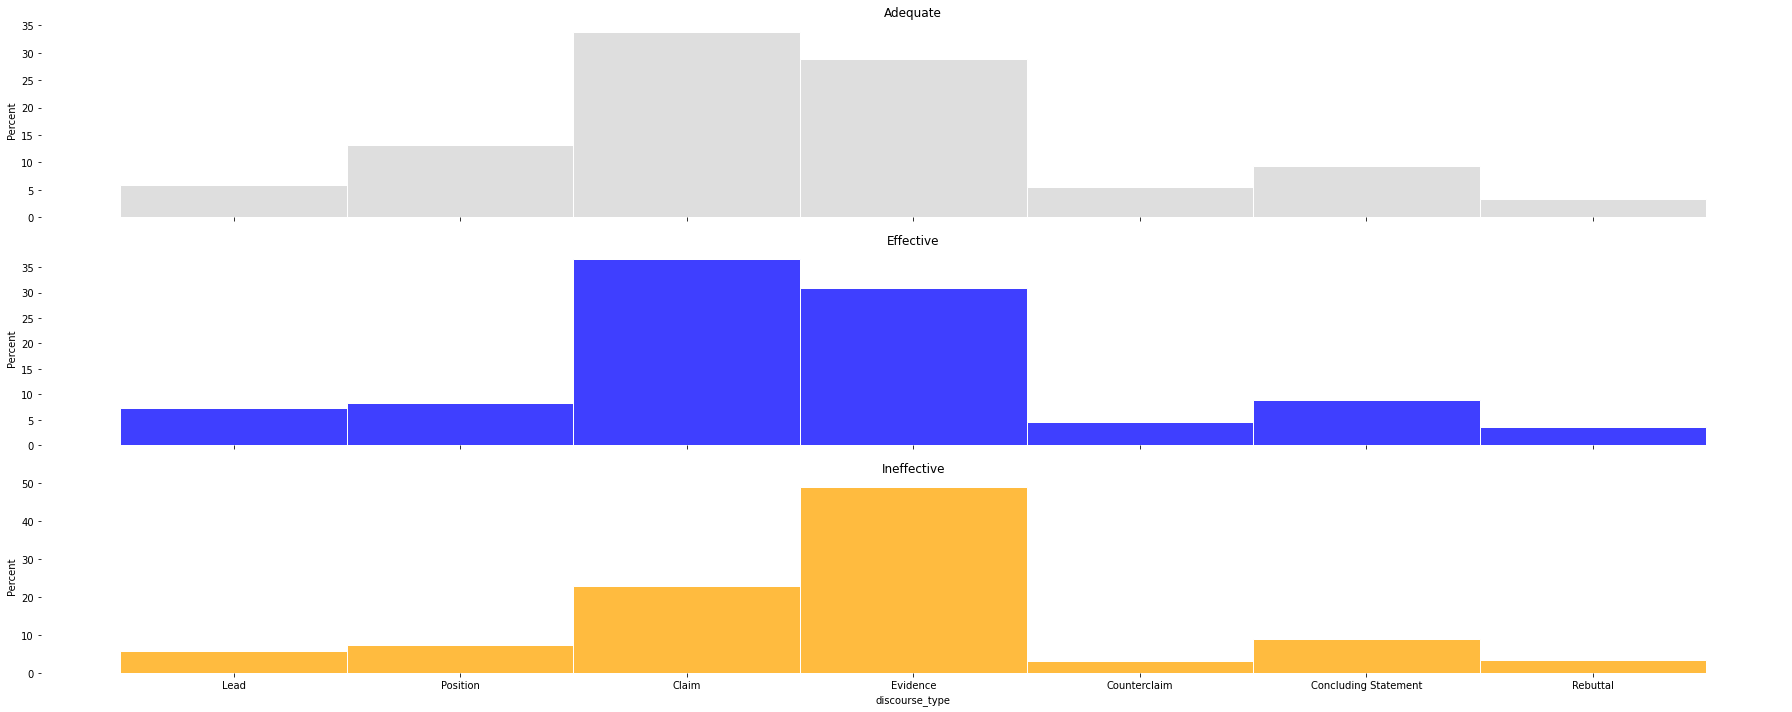

In [321]:
fig,axs = plt.subplots(nrows = train.discourse_effectiveness.nunique(), ncols = 1,figsize= (25,10), sharex = True)

colors = ['lightgray', 'blue', 'orange']

for idx, eff in enumerate(['Adequate', 'Effective', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].discourse_type, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white', color = colors[idx]).set_title(eff)
    axs[idx].set_frame_on(False)

plt.tight_layout()
plt.show()



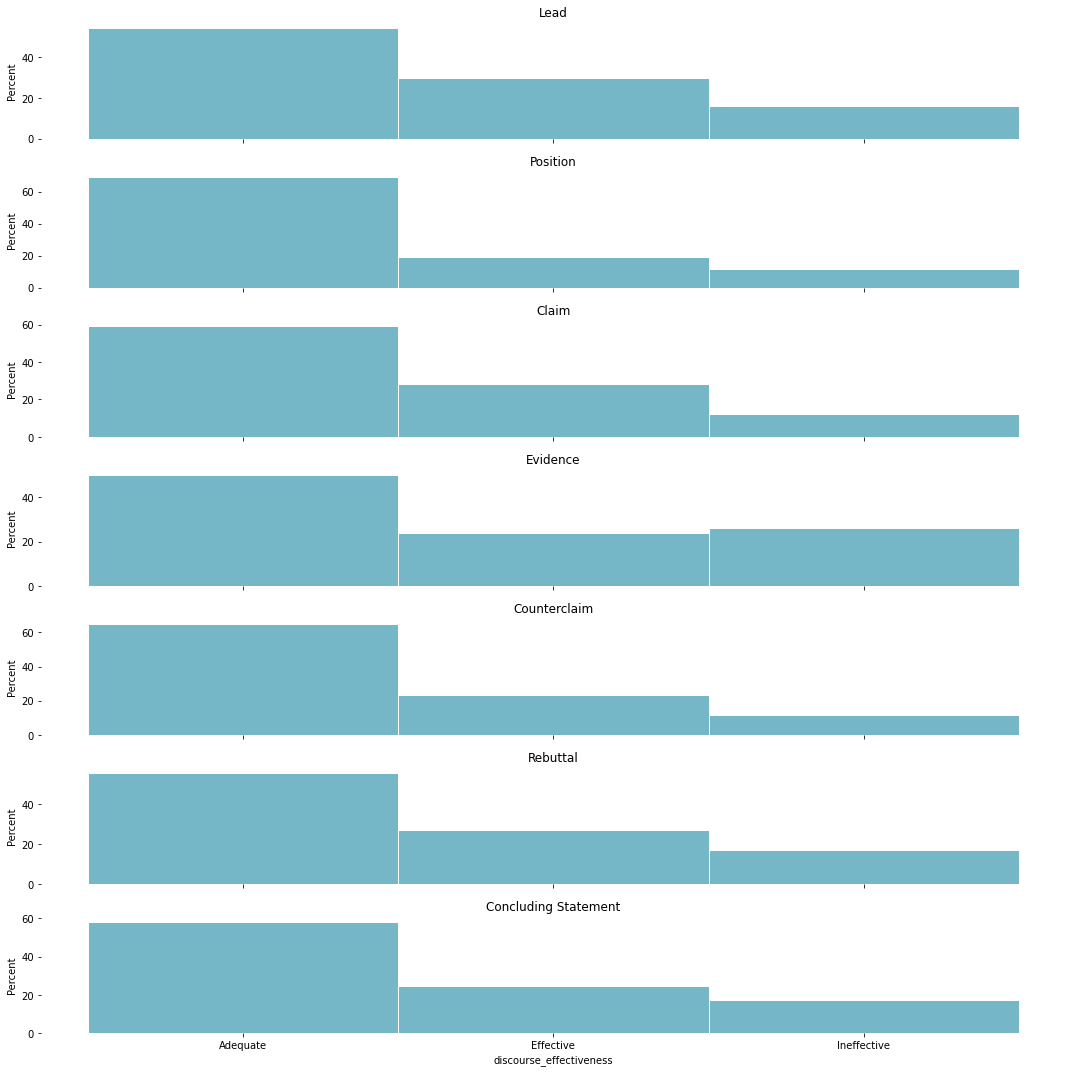

In [394]:
fig, axs = plt.subplots(nrows = 7, ncols = 1, figsize= (15,15), sharex = True)
for idx, eff in enumerate(train.discourse_type.unique()):
    sns.histplot(train[train.loc[:, 'discourse_type'] == eff].discourse_effectiveness, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.show()

In [371]:
np.unique(train.groupby('discourse_text').discourse_type.value_counts().values, return_counts=True)

(array([ 1,  2,  3,  4,  5,  7, 14]),
 array([36656,    30,     5,     2,     1,     1,     1]))

In [373]:
train.discourse_text.nunique()

36691

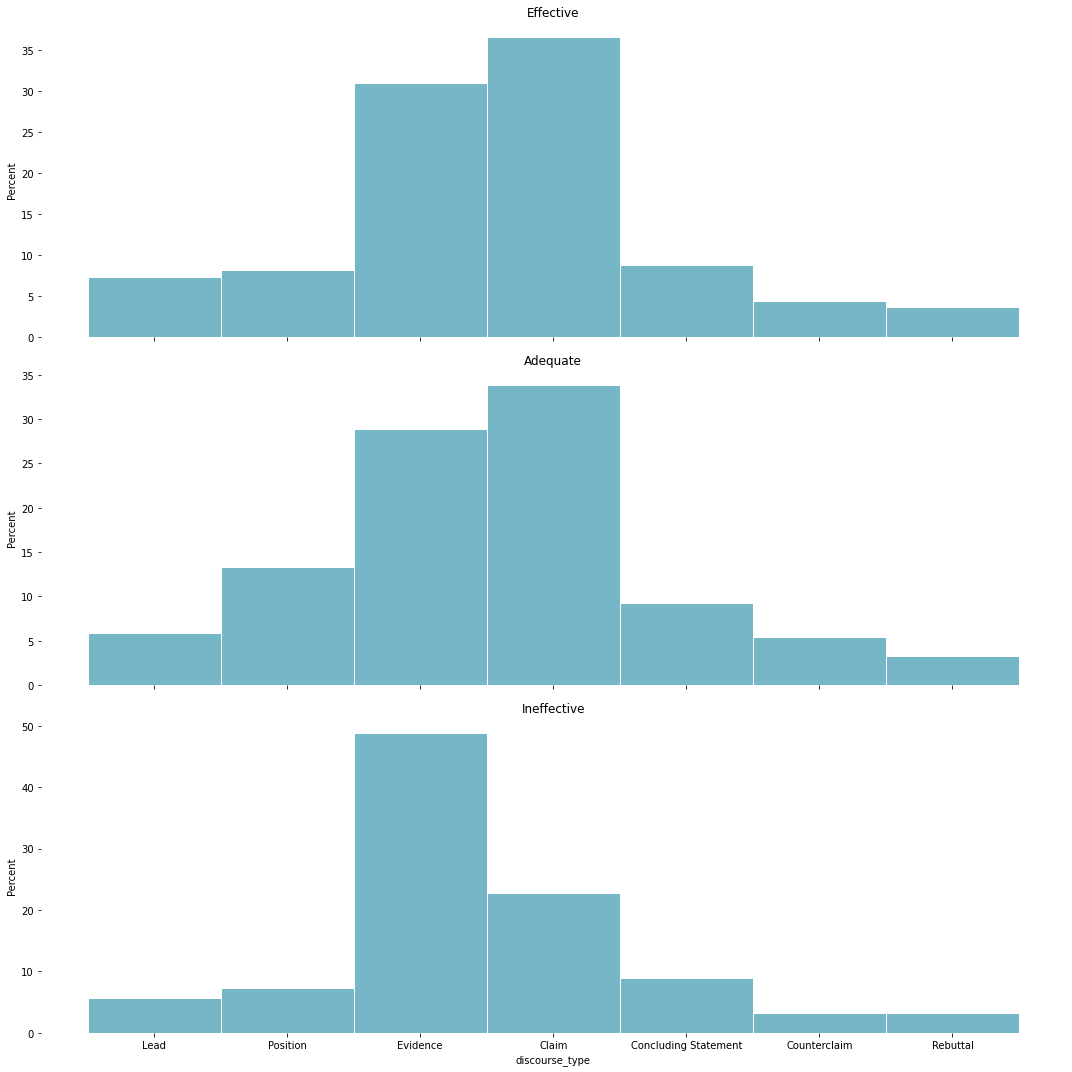

In [395]:
#### TODO: Needs interpretation

fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (15,15), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    sns.histplot(train[train.loc[:, 'discourse_effectiveness'] == eff].discourse_type, ax = axs[idx], stat = 'percent', label=eff, edgecolor = 'white').set_title(eff)
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.show()



In [324]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import wordcloud as wc
from itertools import chain

In [325]:
STOPWORDS = set(stopwords.words('english'))

In [326]:
?wc.WordCloud

Init signature:
wc.WordCloud(
    font_path=None,
    width=400,
    height=200,
    margin=2,
    ranks_only=None,
    prefer_horizontal=0.9,
    mask=None,
    scale=1,
    color_func=None,
    max_words=200,
    min_font_size=4,
    stopwords=None,
    random_state=None,
    background_color='black',
    max_font_size=None,
    font_step=1,
    mode='RGB',
    relative_scaling='auto',
    regexp=None,
    collocations=True,
    colormap=None,
    normalize_plurals=True,
    contour_width=0,
    contour_color='black',
    repeat=False,
    include_numbers=False,
    min_word_length=0,
    collocation_threshold=30,
)
Docstring:     
Word cloud object for generating and drawing.

Parameters
----------
font_path : string
    Font path to the font that will be used (OTF or TTF).
    Defaults to DroidSansMono path on a Linux machine. If you are on
    another OS or don't have this font, you need to adjust this path.

width : int (default=400)
    Width of the canvas.

height : int (defaul

In [327]:
STOPWORDS.update(['people', 'would','student', 'students', 'school'])

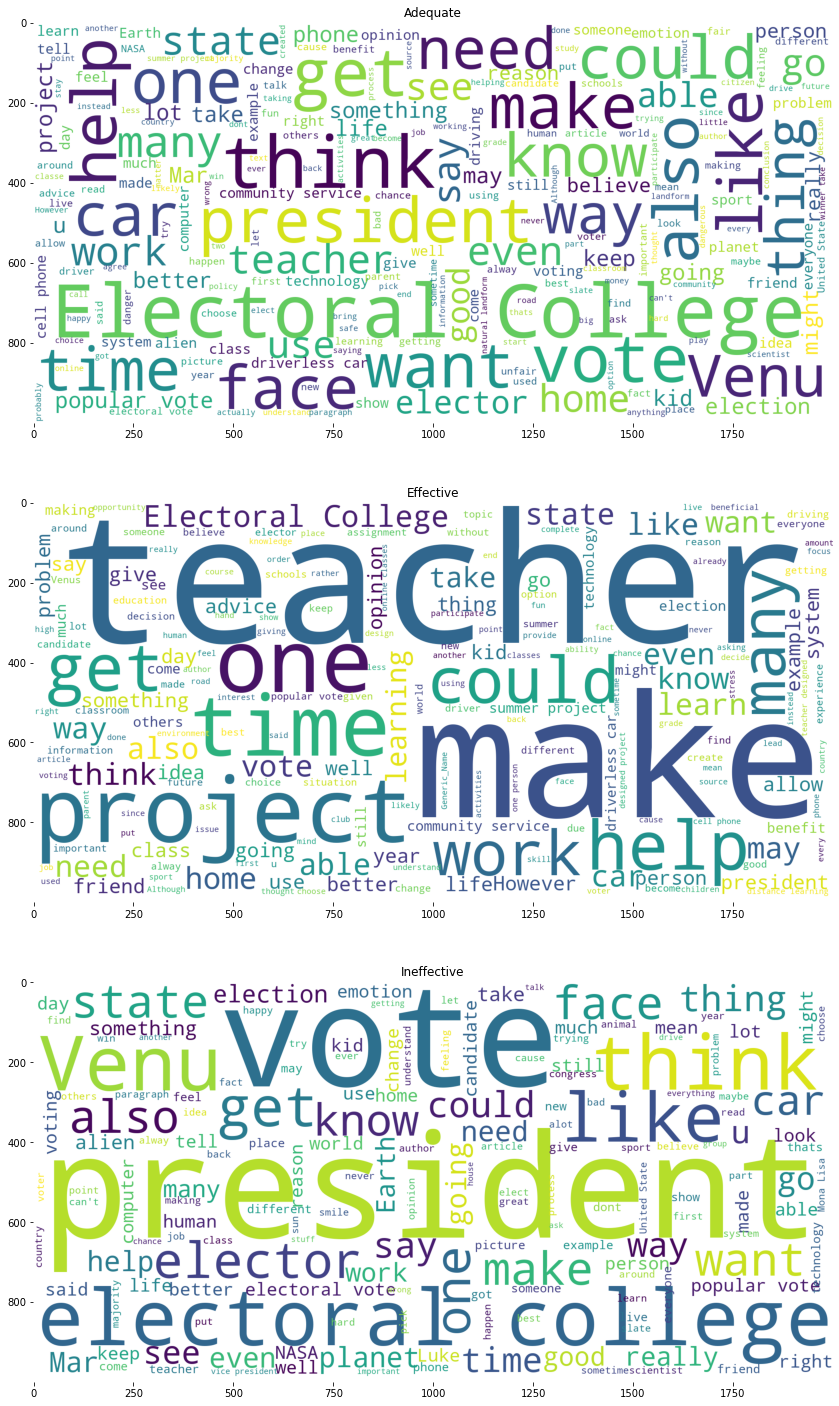

In [328]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (25,25))

for idx, label in enumerate(['Adequate', 'Effective', 'Ineffective']):
    subset = train.loc[train['discourse_effectiveness'] == label,:].discourse_text
    subset = ' '.join(subset)
    cloud = wc.WordCloud(background_color = 'white', scale = 5, stopwords=STOPWORDS, max_words=250).generate(subset)
    axs[idx].imshow(cloud)
    axs[idx].set_title(label)
    axs[idx].set_frame_on(False)
    # tokenized_subset = subset.map(word_tokenize)
    # merged_subset = list(chain(*tokenized_subset.to_list()))
    # cloud = wc.WordCloud(token)    


plt.box(False)
plt.show()

One thing that stood out at a first glance is that in the ineffective class named entities have been not capitalized.
Also, it feels like there are more grammar errors. (?)

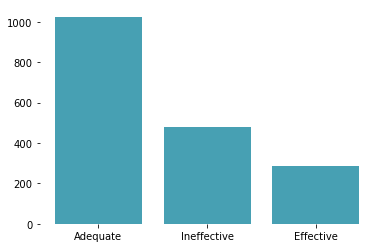

In [329]:
subset = train.loc[train.discourse_text.str.contains('Venus'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

Ineffective    2
Name: discourse_effectiveness, dtype: int64


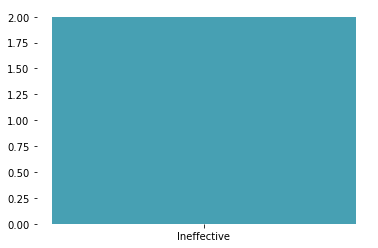

In [330]:
subset = train.loc[train.discourse_text.str.contains('Venu '),:].discourse_effectiveness.value_counts()
print(subset)
plt.bar(x = subset.index, height = subset.values)
plt.box(False)


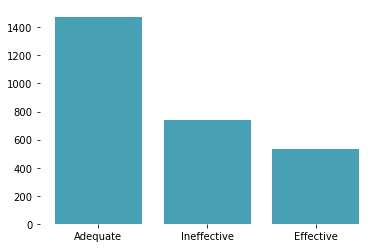

In [331]:
subset = train.loc[train.discourse_text.str.contains('president'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

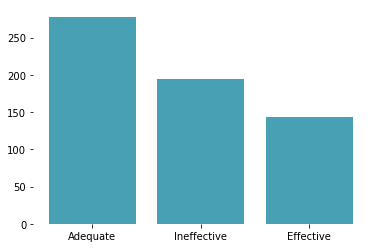

In [332]:
subset = train.loc[train.discourse_text.str.contains('President'),:].discourse_effectiveness.value_counts()
plt.bar(x = subset.index, height = subset.values)
plt.box(False)

In [333]:
from spylls.hunspell import Dictionary
from string import punctuation
import contractions
DICTIONARY = Dictionary.from_files('en_US')
PUNCTUATIONS = set(list(punctuation))

In [334]:
DICTIONARY

In [335]:
contr = contractions.contractions_dict

contractions_new = {}
for key, value in contr.items():
    contractions_new[key.lower()] = value.lower()

def check_word(token):
    if DICTIONARY.lookup(token):
        return 1
    else:
        return 0

def replace_contractions(text):
    for key, value in contractions_new.items():
        text = text.replace(key, value)

    # Remove possesives as well 
    text = text.replace("'s", "")

    return text 

NOT_MISTAKES = ['landform', 'driverless']

def check_in_dictionary(sentences):

    # If the contraction can be removed, than it means it's correct; consequently, only possibly incorrect words remain

    tokenized_sentences = word_tokenize(sentences)
    correct_tokens = [check_word(token) if (token not in PUNCTUATIONS) and (token not in NOT_MISTAKES)  else 1 for token in tokenized_sentences]

    return correct_tokens

def get_incorrect_indices(correct_word_list):
    return [idx for idx, value in enumerate(correct_word_list) if not value]

def get_incorrect_words(words_list, indices):
    return [words_list[idx] for idx in indices]


In [336]:
train 

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,Some people may ask multiple people for advice...
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,Some people may ask multiple people for advice...
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate,Some people may ask multiple people for advice...
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective,Some people may ask multiple people for advice...


In [337]:
train['text_'] = train.discourse_text.map(replace_contractions)

In [338]:
train['tokenized_sentences'] = train.text_.map(word_tokenize)

In [339]:
train['correct_list'] = train.text_.map(check_in_dictionary)

In [340]:
train['incorrect_indices'] = train.correct_list.map(get_incorrect_indices)

In [341]:
train['incorrect_words'] = train.apply(lambda x: get_incorrect_words(x.tokenized_sentences, x.incorrect_indices), axis = 1)

In [342]:
train['incorrect_words_len'] = train.incorrect_words.map(len)

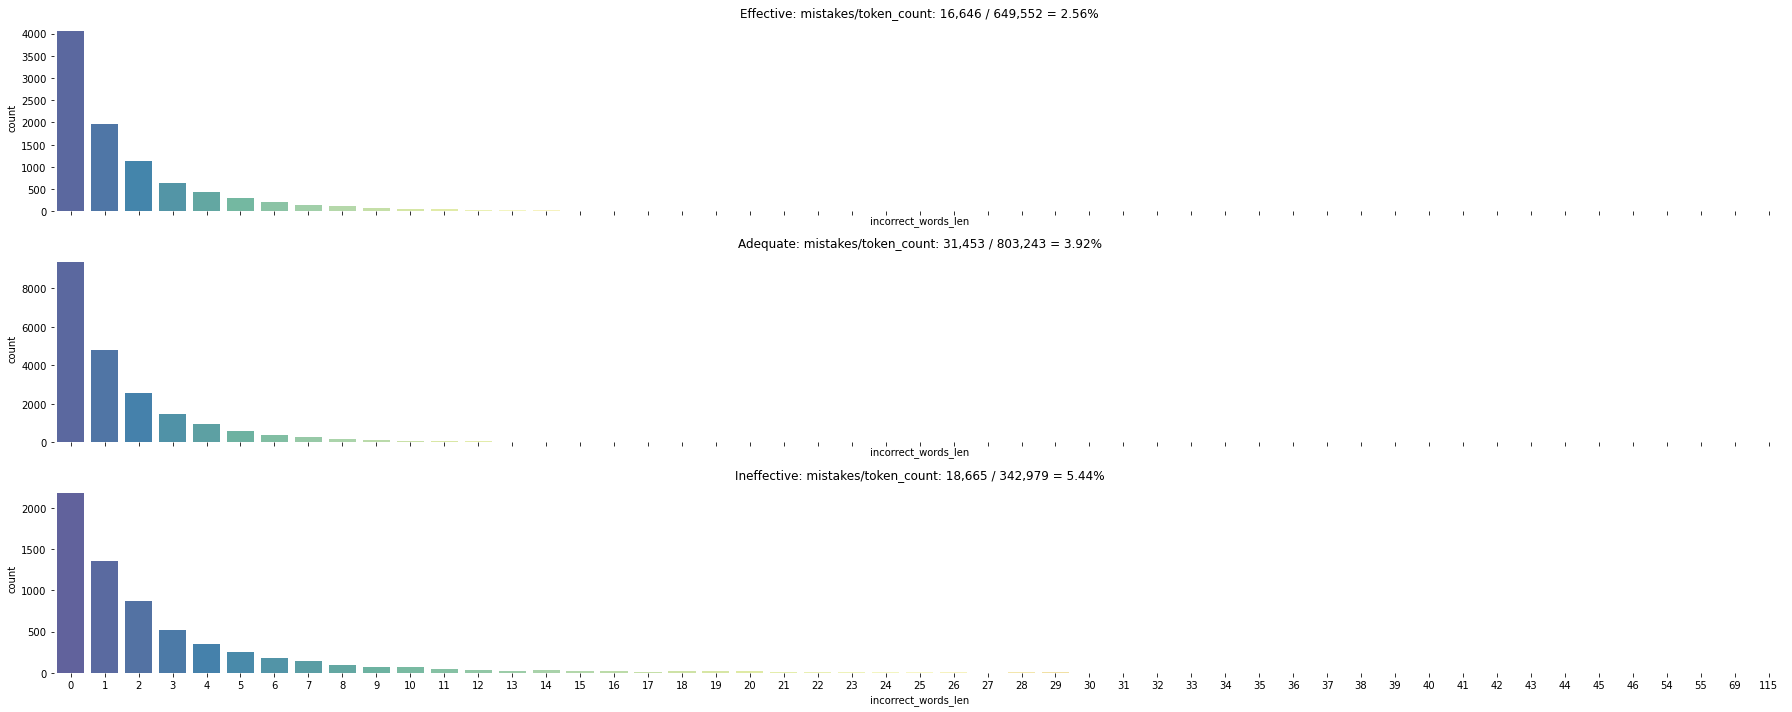

In [359]:
fig, axs = plt.subplots(nrows = 3 , ncols = 1, figsize= (25,10), sharex = True)

for idx, eff in enumerate(['Effective', 'Adequate', 'Ineffective']):
    subset = train.loc[train.discourse_effectiveness == eff].incorrect_words_len
    subset_sum = subset.sum()
    total_token_count = train.loc[train.discourse_effectiveness == eff].tokenized_sentences.map(len).sum()
    sns.countplot(x = subset, ax = axs[idx], palette = 'Spectral_r').set_title(f"{eff}: mistakes/token_count: {subset_sum:,} / {total_token_count:,} = {subset_sum/total_token_count:.2%}") 
    axs[idx].set_frame_on(False)
plt.tight_layout()
plt.box(False)
plt.show()


#### WORDCLOUD for flagged mistakes/typos

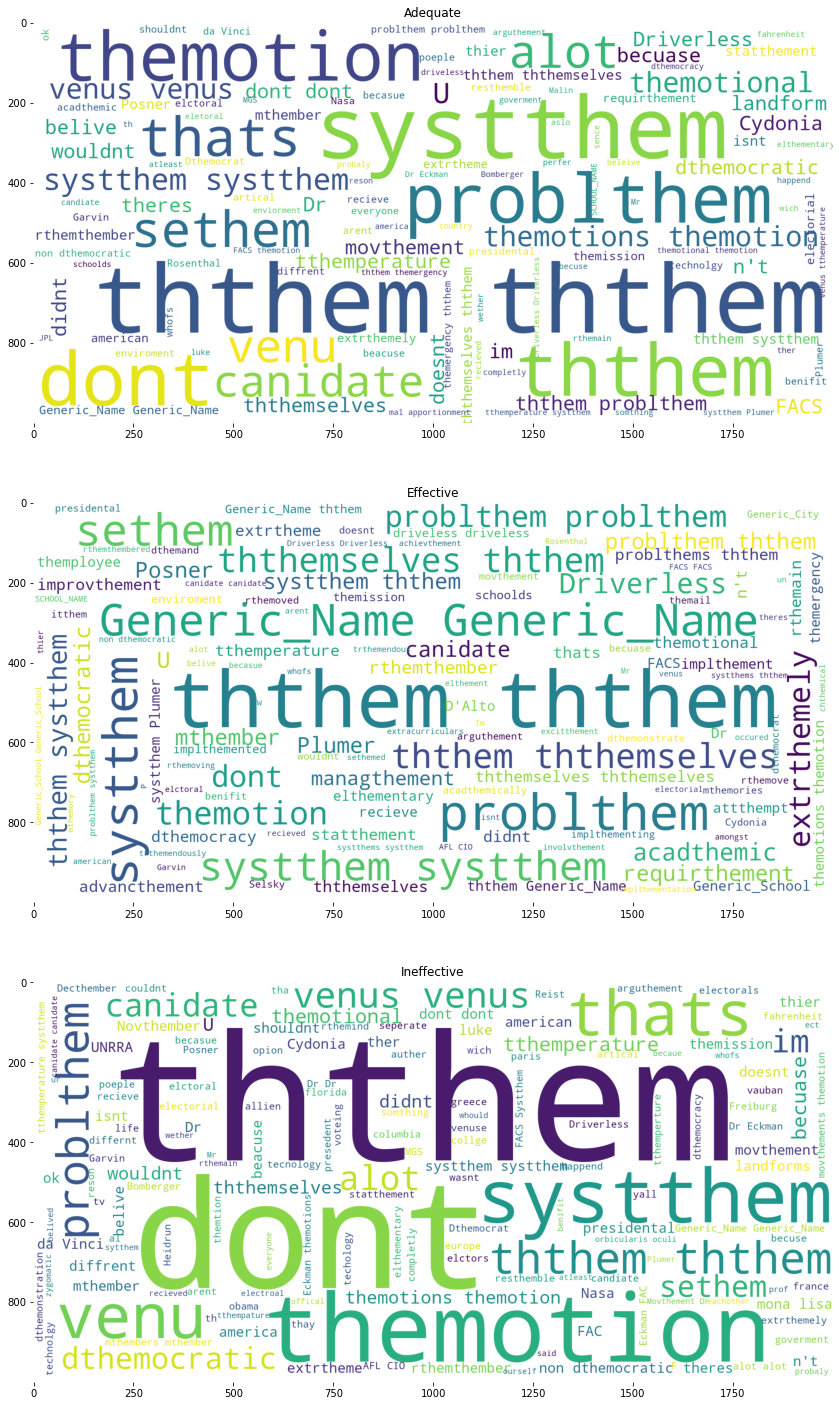

In [344]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize= (25,25))

for idx, label in enumerate(['Adequate', 'Effective', 'Ineffective']):
    subset = train.loc[train['discourse_effectiveness'] == label,:].incorrect_words.map(' '.join)
    subset = ' '.join(subset)
    cloud = wc.WordCloud(background_color = 'white', scale = 5, stopwords=STOPWORDS, max_words=500).generate(subset)
    axs[idx].imshow(cloud)
    axs[idx].set_title(label)
    axs[idx].set_frame_on(False)
    # tokenized_subset = subset.map(word_tokenize)
    # merged_subset = list(chain(*tokenized_subset.to_list()))
    # cloud = wc.WordCloud(token)    


plt.box(False)
plt.show()

#### NER
TODO: Named entity recognition, check if capitalized

#### Relative position of argument in essay

#### Common english words

#### Syllables

In [345]:
from hyphenate import hyphenate_word

In [346]:
train 

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,text_,tokenized_sentences,correct_list,incorrect_indices,incorrect_words,incorrect_words_len
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","Hi, i am Isaac, i am going to be writing about...","[Hi, ,, i, am, Isaac, ,, i, am, going, to, be,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],0
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","On my perspective, I think that the face is a ...","[On, my, perspective, ,, I, think, that, the, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15, 32]","[dont, 'll]",2
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...",I think that the face is a natural landform be...,"[I, think, that, the, face, is, a, natural, la...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[19],[descovered],1
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...","If life was on Mars, we would know by now. The...","[If, life, was, on, Mars, ,, we, would, know, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[41, 47, 49]","[``, Cydonia, '']",3
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about h...",People thought that the face was formed by ali...,"[People, thought, that, the, face, was, formed...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",[8],[alieans],1
...,...,...,...,...,...,...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,Some people may ask multiple people for advice...,For many people they do not like only asking o...,"[For, many, people, they, do, not, like, only,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],0
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,Some people may ask multiple people for advice...,also people have different views and opinions ...,"[also, people, have, different, views, and, op...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[],[],0
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate,Some people may ask multiple people for advice...,Advice is something that can impact a persons ...,"[Advice, is, something, that, can, impact, a, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],0
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective,Some people may ask multiple people for advice...,someone can use everything that many people sa...,"[someone, can, use, everything, that, many, pe...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",[13],[ththem],1
